# TILT - Teemo Induced Loss of Tranquility
A research project to study main factors in inducing tilt.

ONLY LOOKS AT THE PERSON STATS THEMSELVES


# Imports

In [52]:
# from collections import defaultdict
from datetime import datetime
from pathlib2 import Path
from riotwatcher import LolWatcher, ApiError
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier





from tenacity import retry, wait_exponential, stop_after_attempt


# import arrow
# import csv
import itertools
import datetime
# import time
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

%matplotlib inline

# Functions

In [3]:
def touch(path):
    """
    Creates a file if it doesnt exists and also create any directories in the path that do not exist.

    Args:
        path (str): File path.
    Returns:
        None
    """
    basedir = os.path.dirname(path)
    if not os.path.exists(basedir):
        os.makedirs(basedir)
    with open(path, mode="a"):
        pass
        

In [4]:
def api_key(api_key_loc):
    """
    Read in the development API key from a file and checks if it is viable.
    
    Args:
        credentials (str): Name of json file containing the credentials.
    Returns:
        api_key (str): The API key.
    """

    # Keep requestion for a correct key or until canceled
    while True:
        with open(api_key_loc, "r") as credentials:
            creds = json.load(credentials)
            api_key = creds["dev_api_key"]
            lol_watcher = LolWatcher(creds["dev_api_key"])
            try:
                # Validate API key by using it to check server status
                lol_watcher.data_dragon.versions_all()
                # Break if key is functional
                break
            except ApiError as error:
                # If the current API key does not work input new one
                if error.response.status_code == 403:
                    new_api_key = input("API key is incorrect, enter correct key here.")
                    creds["dev_api_key"] = new_api_key
                    # Replace the old API key
                    with open(api_key_loc, "w") as json_data:
                        json.dump(creds, json_data)
    return api_key

In [5]:
def adj_patch_time(reg, patch_nr="now"):
    # TODO: add time epochs instead of patch nrs
    """
    Read the patch number and return the time adjusted for time shift caused by different timezones.  
    Args:
        reg (str): Official registered Riot server that hosts league of legends.
        patch_nr (str): League of legends update patch number. 
            Defaults to "now" which is the current time.
    Returns:
        adj_time (long): Time in (milli)seconds following the Coordinated Universal Time (UTC) format.
    """

    # Read patch data
    patch_loc = proj_dir / "data" / "patches.json"
    with open(patch_loc, "r") as in_file:
        patch_data = json.load(in_file)
    
    # Set the base utc time
    if patch_nr == "now":
        patch_time = int(datetime.utcnow().timestamp())
    else:
        for patch in patch_data["patches"]:
            if patch["name"] == patch_nr:
                patch_time = patch["start"]
    # Check if patch number is valid
    assert patch_time, f"Patch number: {patch_nr} is unknown"

    # Set the time shift
    try:
        reg_shifts = patch_data["shifts"][reg.upper()]
    except KeyError:
        # Check if region provided is valid
        raise KeyError(f"Region: {reg} is unknown")
    
    # Calculate time adjusted for the time shift of the region
    adj_time = patch_time + reg_shifts
    return adj_time

In [6]:
def trans_reg(reg_abbrv):
    """
    Translate a league of legends region into a region readable by riot watcher.
    
    Args:
        reg_abbrv (str): Abbreviation of a official registered Riot servers that
            hosts league of legends (e.g. euw1).
    Returns:
        rw_region (str): Riot Watcher region the reg_abbrv server falls under.
    """
    # Look up in the list what the riot watcher region is for the given region abbreviation
    regions_metadata = {"br1": "americas",
                        "eun1": "europe",
                        "euw1": "europe",
                        "jp1": "asia",
                        "kr": "asia",
                        "la1": "americas",
                        "la2": "americas",
                        "na1": "americas",
                        "oc1": "americas",
                        "tr1": "europe",
                        "ru": "europe"
                        }

    for reg, rw_reg in regions_metadata.items():
        if reg_abbrv.lower() == reg:
            rw_region = rw_reg
    
    return rw_region

In [7]:
@retry(wait=wait_exponential(multiplier=1, min=5, max=60), stop=stop_after_attempt(10))
def get_matches(reg, pid, s_time, e_time):
    """
    Retrieve match IDs from a summoner within a given timeframe.

    Args:
        reg (str): Abbreviation of a official registered Riot servers that
            hosts league of legends (e.g. euw1).
        pid (str): An Encrypted globally unique identifyer for a summoner.
        s_time (long): Start of a timeframe in (milli)seconds following
            the Coordinated Universal Time (UTC) format.
        e_time (long): end of a timeframe in (milli)seconds following
            the Coordinated Universal Time (UTC) format.
    Returns:
        matches (list): League of legends match IDs in chronological order
            starting with the most recent match.
    """

    # Retrieve all match ID's between two time points
    rw_reg = trans_reg(reg)
    matches = lol_watcher.match.matchlist_by_puuid(region=rw_reg,
                                                   puuid=pid,
                                                   start_time=s_time,
                                                   count=100,
                                                   queue=420,
                                                   end_time=e_time)
    
    # Geather more match IDs in case matches exceeds the standard limit of 100
    while len(matches) % 100 == 0 and len(matches) != 0:
        # Geather match details of earliest match
        match_deets = lol_watcher.match.by_id(rw_reg, matches[-1])
        # Start time of earliest match
        early_g_start = int(str(match_deets["info"]["gameCreation"])[:10])
        # Select 100 matches previous to early_g_start  
        match_add = lol_watcher.match.matchlist_by_puuid(region=rw_reg,
                                                         puuid=pid,
                                                         start_time=s_time,
                                                         count=100,
                                                         queue=420,
                                                         end_time=early_g_start)
        if len(match_add) == 0:
            break
        else:
            matches.extend(match_add)

    return matches

In [8]:
@retry(wait=wait_exponential(multiplier=1, min=5, max=60), stop=stop_after_attempt(10))
def geather_data(puuid, matches):
    """
    Geather summoner data from a match and chronology data of the match.
    
    Args:
        puuid (str): An Encrypted globally unique identifyer for a summoner.
        matches (list): League of legends match IDs in chronological order
                        starting with the most recent match.  
    Returns:
        df_matches_data (df): Data geathered from matches of a summoner.
    """
    
    game_info = ["gameCreation", "gameStartTimestamp"]
    keep_data = ["puuid", "teamPosition", "kills", "assists", "deaths", 
                 "doubleKills", "tripleKills", "quadraKills", "pentaKills", 
                 "killingSprees", "largestKillingSpree", 
                 "gameEndedInEarlySurrender", "teamEarlySurrendered", "gameEndedInSurrender",
                 "neutralMinionsKilled", "totalMinionsKilled", "teamId", "win", "timePlayed"]

    col_names = ["match_id", "puuid", "pos", "kills", "assists", "deaths", 
                 "2_kills", "3_kills", "4_kills", "5_kills", 
                 "kill_spree", "max_kill_spree", 
                 "remake", "pre_15_surr", "game_surr",
                 "neutral_kills", "minion_kills", "team_id", "win",
                 "time_played", "game_make", "game_start"]
      
    comp_data = []
    # Geather match details
    for match_id in matches:
        reg = match_id.split("_")[0].lower()
        match_deets = lol_watcher.match.by_id(trans_reg(reg), match_id)

        # Collect time data
        time_data = dict((key, match_deets["info"][key]) for key in game_info)

        # Collect summoner data       
        for part_info in match_deets["info"]["participants"]:
            if part_info["puuid"] == puuid:
                filt_data = dict((key, part_info[key]) for key in keep_data)
        match_data = {"match_id": match_id} | filt_data | time_data
        comp_data.append(match_data.values())
    
    # Store all data in a dataframe
    df_matches_data = pd.DataFrame(comp_data, columns=col_names)

    return df_matches_data
    

In [9]:
def filt_matches(matches_data, max_rest, min_streak):
    """
    Filter matches based on rest time in between matches and number of matches played in a row.  
    
    Args:
        matches_data (df): Data geathered from matches of a summoner.
        max_rest (int): Rest time in between matches in miliseconds e.g. 3600000 = 1 hour.
        min_streak (int): Minimum games played in a row with less then max_rest between.
    Returns:
        df_match_filt (df): Matches filtered based on minimum subsequent matches within
            the maximum rest time in between the matches.
    """
      
    # Add rest time between previous and next match to base the filtering of on
    df_match_filt = matches_data 
    df_match_filt["game_end"] = df_match_filt.loc[:,["game_start", "time_played"]].sum(axis=1)
    df_match_filt["prev_game_end"] = df_match_filt["game_end"].shift(-1, fill_value=np.nan)
    df_match_filt["next_game_make"] = df_match_filt["game_make"].shift(1, fill_value=np.nan)
    df_match_filt["time_since_last"] = df_match_filt["game_make"] - df_match_filt["prev_game_end"]
    df_match_filt["time_till_next"] = df_match_filt["next_game_make"] - df_match_filt["game_end"]
    
    # Filter for matches based on rest time below the max_rest time

    # Find games that were played in a streak by grouping based on matches played subsequently
    # Copy index to know where a empty line was inserted
    df_match_filt["idx"] = df_match_filt.index
    # Add empty lines between groups to split them up
    indices = np.where((df_match_filt["time_till_next"] >= max_rest) | (np.isnan(df_match_filt["time_since_last"].shift(-1))))[0]
    rows_ = dict.fromkeys(df_match_filt.columns.tolist(), np.nan)
    # Add empty lines
    df_match_filt = pd.DataFrame(np.insert(df_match_filt.values, [x for x in indices],
                                           values=list(rows_.values()),
                                           axis=0),columns=rows_.keys())

    # Temporarily store streak_id to know how big the groups are
    game_streak = df_match_filt["idx"].diff().ne(1).cumsum()
    df_match_filt["streak_id"] = df_match_filt.groupby(game_streak).ngroup()
    # Filter out streaks that are lower then min_streak
    df_match_filt = df_match_filt[df_match_filt["idx"].groupby(game_streak).transform("count") >= min_streak]
    
    # Clean up
    # Drop all empty rows
    df_match_filt = df_match_filt[df_match_filt["idx"].notna()]

    # Change all values above max_rest to nan
    df_match_filt["time_since_last"] = np.where(df_match_filt["time_since_last"] >= max_rest , np.nan, df_match_filt["time_since_last"])
    
    return df_match_filt


In [10]:
def get_summoner_data(regs, tiers, divs, sum_lim, p_patch, r_patch, max_rest, min_streak, sumo_data_loc):
    """
    Get puuid's, tier and division, from all regions that are in ranks below master rank ((random?) above bronze?).
    
    Args:
        regs (list): Official registered Riot servers that hosts league of legends.
        tier (list): Tiers below Master rank.
        divs (list): Divisions in roman numerals.
        sum_lim (int): Maximum number of summoner ids to collect per region, tier and division.
        p_patch (str): A patch prior to then r_patch's patch.
        r_patch (str): A more recent patch then p_patch's patch.
        max_rest (int): Rest time in between matches in miliseconds e.g. 3600000 = 1 hour.
        min_streak (int): Minimum games played in a row with less then max_rest between.
        sumo_data_loc (str): location to store the info on the summoner and game statistics.
    Returns:
        None
    """
    
    for reg, tier, div in itertools.product(regs, tiers, divs):
        summs_div = 0
        page_nr = 0
        # Keep adding new summoners until the summoner limit has been reached
        while summs_div < sum_lim:
            page_nr += 1
            summs = lol_watcher.league.entries(reg, "RANKED_SOLO_5x5", tier, div, page_nr)
            # Look into data per summoner
            for sumo in summs:
                if summs_div < sum_lim:
                    # Get PUUID
                    pid = lol_watcher.summoner.by_id(reg, sumo["summonerId"])["puuid"]

                    # Retrieve all match ID's between two time points
                    match_ids = get_matches(reg, pid, adj_patch_time(reg, p_patch), adj_patch_time(reg, r_patch))
                    # Skip summoners that have no matches in the given time frame 
                    if not match_ids:
                        continue
        
                    # Geather match data of the summoner
                    match_info = geather_data(pid, match_ids)

                    # Filter matches
                    filt_match_info = filt_matches(match_info, max_rest, min_streak)
                    # Skip summoners that have no matches left after filtering
                    if filt_match_info.empty:
                        continue
                    
                    # Add summoner rank information 
                    cur_rank = f"{tier}_{div}"
                    filt_match_info.insert (2, "rank", cur_rank)

                    # Increase the summoner counter
                    summs_div += 1
                    
                    # Store summoner data in a tsv file
                    file_true = sumo_data_loc.exists()
                    filt_match_info.to_csv(sumo_data_loc,
                                           header=not file_true,
                                           mode="a" if file_true else "w",
                                           sep="\t",
                                           index=False)

In [11]:
def prep_data(df_match_filt, out_file):
    """
    Preprocess the df_match_filt, manipulation and dropping some data to make to ready for use.  
    
    Args:
        df_match_filt (df): Matches filtered based on minimum subsequent matches within
            the maximum rest time in between the matches.
    Returns:
        None
    """

    # Beautification of dataframe
    # Move information of next game to next line by reversing the dataframe. Games played first (oldest) are on top 
    df_match_prep = df_match_filt[::-1]
    
    # Redo the streak_id numbers
    streak_id_ident = df_match_prep["streak_id"].diff().ne(0).cumsum()
    idx_consec = df_match_filt["idx"].diff().ne(1).cumsum()
    df_match_prep["streak_id"] = df_match_prep.groupby([streak_id_ident, idx_consec]).ngroup()
    
    # Add informational columns

    # Clean up the dataframe
    # Dropping columns used for calculations that are not needed anymore
    col_drop = ["game_start", "game_end", "prev_game_end", "next_game_make", "time_till_next", "idx"]
    df_match_prep.drop(columns=col_drop, axis=1, inplace = True)

    # Store the dataframe
    df_match_prep.to_csv(out_file,
                         mode="w",
                         sep="\t",
                         index=False)
    return df_match_prep

# Global variables and settings

In [12]:
# Directory locations

# Project folders
proj_dir = Path.cwd().parent

# Raw data storage
data_dir = proj_dir / "data"

# Out dir
out_dir = proj_dir / "out"

# Gobal variables

# Set API key
api_key_loc = data_dir / "dev_api_key.json"

# Enter API key
lol_watcher = LolWatcher(api_key(api_key_loc))

# Read user settings
settings_loc = proj_dir / "settings" / "config.json"
with open(settings_loc, "r") as settings_data:
    settings = json.load(settings_data)

# Data collection

In [ ]:
# Retrieve the summoner info of n summoners per rank (tier and division) 

# Remove output file if it exists
raw_sumo_data = data_dir / "summoner_data_raw.tsv"

while Path(raw_sumo_data).exists():
    answer = input("""Enter "yes" to overwrite file, or enter new filepath""")
    if answer.upper() in ["Y", "YES"]:
        os.remove(raw_sumo_data)
    else:
        raw_sumo_data = answer
        touch(raw_sumo_data)
        
get_summoner_data(regs=settings["regions"],
                  tiers=settings["tiers"],
                  divs=settings['divisions'],
                  sum_lim=settings['summoner_limit'],
                  p_patch=settings["prior_patch"],
                  r_patch=settings["recent_patch"],
                  max_rest=settings["max_rest"],
                  min_streak=settings["min_streak"],
                  sumo_data_loc=raw_sumo_data)


# Preprocessing

In [47]:
# Note: If slow consider storing as a pickle object or just add this to the data collection step
# Read in the summoner data
sumo_info_raw_loc = data_dir / "summoner_data_raw.tsv"
sumo_info_raw = pd.read_csv(sumo_info_raw_loc, sep = "\t")

# Preprocessing
sumo_data_loc = out_dir / "prep_sumo_data.tsv"
sumo_info = prep_data(sumo_info_raw, sumo_data_loc)

sumo_info.head()

# TODO: Remove this after the data has been geatehr again after 21-6 (this has been moved to filtering so wont work in prep)
# Change all values above max_rest to nan
sumo_info["time_since_last"] = np.where(sumo_info["time_since_last"] >= 3600000 , np.nan, sumo_info["time_since_last"])
    

# Data Analysis
Main question when should you stop playing and take a chill pill


## Base lines

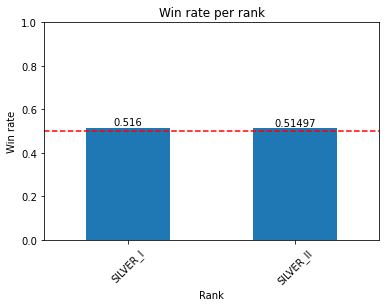

In [449]:
# Calculate average win rate per rank
df_win_rank = sumo_info.groupby("rank")["win"].mean().reset_index()

# Plot the graph
ax = df_win_rank.plot(x="rank",
                 y="win",
                 kind="bar",
                 title="Win rate per rank",
                 ylim=[0, 1],
                 legend=False,
                 xlabel="Rank",
                 ylabel="Win rate")
# Add values to bar for better visibility
ax.bar_label(ax.containers[0], label_type="edge")
# Rotate X_axis label 45 degree
plt.xticks(rotation=45)
# Add horizontal line at the 50% winrate
plt.axhline(y=0.5, linestyle="dashed", color="r")
plt.show()


## When do players play?

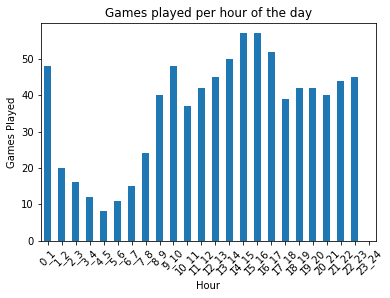

In [347]:
# Games played during each hour of the day

# Retrieve hour of the day from epoch
sumo_info["hour"] = pd.to_datetime(sumo_info["game_make"], unit = "ms").dt.hour
# Create bins
time_bins = np.arange(0, 25, 1) # 24 hours
# Labels for bins
labels = []
for time in time_bins:
    labels.append(f"{time_bins[time]}_{time_bins[time] + 1}") 
labels = labels[0:-1]
# Bin the data
sumo_info["time_bins"] = pd.cut(sumo_info["hour"], bins=time_bins, labels=labels, include_lowest=True)

# Calculate how many people play at what hour of the day
df_time_play = sumo_info.groupby(["time_bins"]).size().to_frame("size").reset_index()

# Plot the graph
ax = df_time_play.plot(x="time_bins",
                  y="size",
                  kind="bar",
                  title="Games played per hour of the day",
                  legend=False,
                  xlabel="Hour",
                  ylabel="Games Played")
# Rotate X_axis label 45 degree
plt.xticks(rotation=45)
plt.show()

## Effect of rest

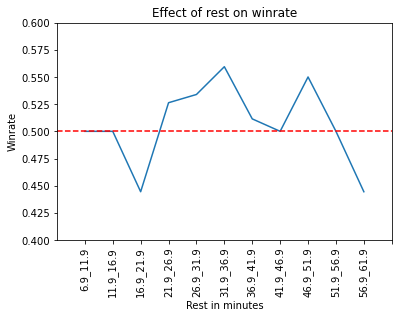

In [427]:
# Rest time vs win rate plot

# Define time bins
min_time = int(sumo_info.time_since_last.min())
max_time = int(sumo_info.time_since_last.max())
block = 300000 # minutes of rest * 60000 = epoch minutes
rest_bins = np.append(np.arange(min_time, max_time, block), max_time)
# Labels for bins
labels = []
for time in rest_bins:
    time_1 = np.around(time / 60000, decimals=1)
    time_2 = np.around((time + block) / 60000, decimals=1)
    labels.append(f"{time_1}_{time_2}") 
labels = labels[0:-1]
# Bin the data
sumo_info["rest_bins"] = pd.cut(sumo_info["time_since_last"], rest_bins, labels=labels, include_lowest=True)

# Calculate the mean win rate per bin
df_time_win = sumo_info.groupby("rest_bins")["win"].mean().reset_index()

df_time_win
# Plot the graph
# Change the X ticks
levels = len(sumo_info["rest_bins"].unique())
x_ticks = np.arange(0, levels + 1, 1)
# TODO: Error bars use yerr = error,
# error = sumo_info.groupby("rest_bins")["win"].std()
# Plot
ax = df_time_win.plot(x="rest_bins",
                 y="win",
                 kind="line",
                 title="Effect of rest on winrate",
                 legend=False,
                 xticks=x_ticks,
                 xlim=[-1, 11],
                 ylim=[0.4, 0.6],
                 xlabel="Rest in minutes",
                 ylabel="Winrate")
# Rotate X_axis label 45 degree
plt.xticks(rotation=90)
# Add horizontal line at the 50% winrate
plt.axhline(y=0.5, linestyle="dashed", color="r")
plt.show()

## Tilted or in the zone?

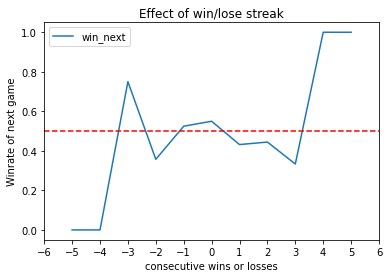

In [340]:
# Win rate during points a win or lose streak
# Calculate the number of games won and lost in succesion per groep of games played within max_rest time of one another 
game_streak = sumo_info["streak_id"].diff().ne(0).cumsum()
sumo_info["consec_wl"] = sumo_info.win.groupby((sumo_info.win != sumo_info.groupby(game_streak)["win"].shift()).cumsum()).cumcount()
# Turn streak values negative if the game ended in a loss
sumo_info.loc[sumo_info.loc[:, "win"] == False, "consec_wl":] *= -1
# Add if the next game is a win or lose
sumo_info['win_next'] = sumo_info.groupby(game_streak)["win"].shift(-1, fill_value=np.nan)
# Calculate mean win rate
df_streak_win = sumo_info.groupby(["consec_wl"])["win_next"].mean().reset_index()
# Optional: Calculate mean win rate taking into account their rank. Need to adjut plot then 
# df_streak_win = sumo_info.groupby(["rank", "consec_wl"])["win_next"].mean().reset_index()

# Plot the graph
# Change the X ticks
min_num = sumo_info["consec_wl"].min()
max_num = sumo_info["consec_wl"].max()
x_ticks = np.append(np.arange(min_num, max_num, 1), max_num)
# Plot
ax = df_streak_win.plot(x="consec_wl",
                        y="win_next",
                        kind="line",
                        title="Effect of win/lose streak",
                        legend=True,
                        xticks=x_ticks,
                        # ylim=[0, 1],
                        xlabel="consecutive wins or losses",
                        ylabel="Winrate of next game")
# Add horizontal line at the 50% winrate
plt.axhline(y=0.5, linestyle="dashed", color="r")
plt.show()

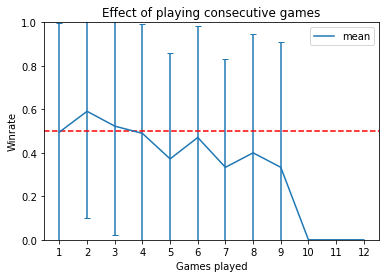

In [480]:
# TODO: apply this method of error bars and graphs to all others if required
# Win rates based on played games in a streak
# Calculate the average win rate of each players first second third etc. game
sumo_info["game_nr"] = sumo_info.groupby("streak_id")["puuid"].rank(method="first", ascending=True)
df_win_game = sumo_info.groupby(["game_nr"])["win"].agg([np.mean, np.std]).reset_index()

# Plot the graph
# Change the X ticks
max_num = df_win_game["game_nr"].max()
x_ticks = np.arange(1, max_num + 1, 1)
# Plot
ax = df_win_game.plot(x="game_nr",
                      y="mean",
                      kind="line",
                      title="Effect of playing consecutive games",
                      legend=True,
                      xticks=x_ticks,
                      ylim=[0, 1],
                      xlabel="Games played",
                      ylabel="Winrate",
                      yerr="std",
                      capsize=3)

# Add horizontal line at the 50% winrate
plt.axhline(y=0.5, linestyle="dashed", color="r")
plt.show()


# Win prediction

## Machine learning aproaches

In [61]:
# Preprocessing
# Drop remake rows:
df = sumo_info.drop(sumo_info[sumo_info.remake == True].index).dropna()

# drop useless columns:
bad_cols = ["match_id", "puuid", "rank", "pos", "remake", "pre_15_surr"]
df.drop(bad_cols, axis = 1, inplace=True)
df


,kills,assists,deaths,2_kills,3_kills,4_kills,5_kills,kill_spree,max_kill_spree,game_surr,neutral_kills,minion_kills,team_id,win,time_played,game_make,time_since_last,streak_id
833,0,16,3,0,0,0,0,0,0,False,0,9,200,True,2042,1626651037000,2276323.0,0
832,1,21,5,0,0,0,0,0,0,False,0,6,100,False,1900,1626654107000,2821847.0,0
831,0,3,4,0,0,0,0,0,0,False,0,2,100,False,1241,1626656433000,2265370.0,0
830,3,23,1,0,0,0,0,1,3,False,0,8,200,True,1987,1626658144000,1621635.0,0
828,0,22,2,0,0,0,0,0,0,False,0,4,200,True,1706,1627070207000,2972576.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,1,4,11,0,0,0,0,0,0,False,0,117,200,False,1320,1626622014000,2341647.0,218
4,14,4,5,2,1,0,0,3,6,False,22,178,100,True,1735,1626624564000,2468776.0,218
3,11,16,3,2,0,0,0,3,5,False,15,178,200,True,1614,1626626833000,2191050.0,218
1,4,1,6,0,0,0,0,1,2,False,8,120,200,False,1524,1629021469000,2692971.0,219


In [62]:
# Split the data into a training and test set
X = df.drop("win", axis=1)
y = df["win"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


ordered_rank_features = SelectKBest(score_func=f_classif, k="all")
ordered_features = ordered_rank_features.fit(X_train, y_train)


In [68]:
# Train models
models = {
    "Logistic Regression": LogisticRegression(max_iter=100),
    "Support Vector Machine (Linear Kernel)": LinearSVC(),
    "Support Vector Machine (RBF Kernel)": SVC(),
    "Decission Tree": DecisionTreeClassifier(),
    "Adaboost": AdaBoostClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier()
}

for name, model in models.items():
  model.fit(X_train, y_train)
  print(name + ' trained')

Logistic Regression trained
Support Vector Machine (Linear Kernel) trained
Support Vector Machine (RBF Kernel) trained
Decission Tree trained


c:\Users\Ryan\miniconda3\envs\tilt\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Adaboost trained
Random Forest trained
Gradient Boosting Classifier trained


In [69]:
from sklearn.metrics import accuracy_score, precision_score,recall_score,f1_score

scores_list = []
for name,model in models.items():
  scores_list.append(
        {
            "Model": name,
            "Accuracy": accuracy_score(y_test, model.predict(X_test)),
            "Precision": precision_score(y_test, model.predict(X_test)),
            "Recall": recall_score(y_test, model.predict(X_test)),
            "F1-Score": f1_score(y_test, model.predict(X_test))
        }
    )

scores_2 = pd.DataFrame(scores_list)
scores_2

c:\Users\Ryan\miniconda3\envs\tilt\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.509934,0.509934,1.000000,0.675439
1,Support Vector Machine (Linear Kernel),0.490066,0.000000,0.000000,0.000000
2,Support Vector Machine (RBF Kernel),0.509934,0.509934,1.000000,0.675439
3,Decission Tree,0.695364,0.696203,0.714286,0.705128
4,Adaboost,0.721854,0.705882,0.779221,0.740741
5,Random Forest,0.754967,0.727273,0.831169,0.775758
6,Gradient Boosting Classifier,0.741722,0.706522,0.844156,0.769231


## Dimension reduction


<AxesSubplot:>

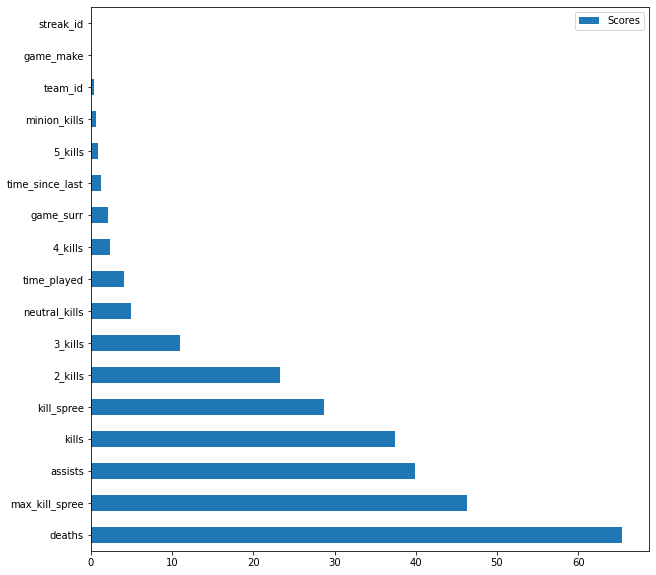

In [72]:

ordered_rank_features = SelectKBest(score_func=f_classif, k="all")
ordered_features = ordered_rank_features.fit(X_train, y_train)
features = pd.DataFrame(ordered_features.scores_, index=X.columns,
columns=["Scores"]).sort_values(by="Scores", ascending=False)
features.plot(kind='barh',figsize=(10,10))

In [ ]:
# Future plans:
# define good and bad stats using medians/average normal dist? 
# Win rate in next game after losing with bad stats
# Win rate in next game after losing with good stats
# Win rate in next game after winning with bad stats
# Win rate in next game after winning with good stats


# Some information about tilt
definition of tilt in league of legends and what causes it : https://dl.acm.org/doi/pdf/10.1145/3411764.3445143
or https://www.diva-portal.org/smash/record.jsf?pid=diva2%3A1591520&dswid=8002

